In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import scipy.linalg as lg

In [12]:
dt = 0.0001
t = 4.0000
step = int(t/dt)
fns = 100
hbar = 1 
gamma = 1
w_t = 1.0 * 2 * np.pi
tlist = np.arange(0,4.0001,dt)
print(tlist.shape)
print(step)

(40001,)
40000


In [13]:
def a(n):
    '''
        returns the annihilation operator for maximum n photons
    '''
    a = np.zeros((n+1,n+1))
    b = np.arange(1,n+1)
    np.fill_diagonal(a[:,1:],np.sqrt(b))
    return a

def adagger(n):
    '''
        returns the creation operator for maximum n photons
    '''
    return a(n).conj().T


In [14]:
# creating time evolution operator when no jump happens 

H = w_t * np.dot(adagger(1),a(1))

H_eff = H - ((1j)*hbar*gamma)/2 * np.dot(adagger(1),a(1)) 
U = np.eye(2) - ((1j)*dt)/hbar * H_eff

print(H)

# L operator

L = np.sqrt(gamma) * a(1)
print(L)



[[0.         0.        ]
 [0.         6.28318531]]
[[0. 1.]
 [0. 0.]]


In [16]:
# initialising the wave function 
psi_0 = np.array([[1/np.sqrt(2)],[1/np.sqrt(2)]])

#dp = gamma*dt* psi_0[1,0]**2

#print(np.dot(L,psi_0)/np.sqrt(dp/dt))

# initial evolution 

#psi_f = np.zeros((2,1))
#print(psi_0)
#psi_f = np.dot(U,psi_0)
print(psi_f)
#k = lg.norm(psi_f)
#print(k)


[[0.70712439+0.j        ]
 [0.7070534 -0.00088855j]]


In [17]:
#H = np.array([[-1*1j*hbar*gamma*(1/2), -3*hbar*gamma],[ -3*hbar*gamma, 0]])
print(H)
#k = (1/hbar) * H
#U = np.eye(2) - 1j * (1/hbar)* dt * H
U_dagger = U.conj().T




[[0.         0.        ]
 [0.         6.28318531]]


In [18]:
def QMCWF(U,L,psi_0,step):
    
    psi_f = psi_0
    psi_n = psi_0
    prob_g = np.zeros(step+1)
    prob_e = np.zeros(step+1)
    prob_g[0] = abs(psi_0[0,0])**2
    prob_e[0] = abs(psi_0[1,0])**2
    
    for t in range(step):
        size = np.dot(np.dot(psi_0.conj().T,U_dagger),np.dot(U,psi_0))
        no_jump_prob = float(size[0,0])
        epsilon = random.rand()
        if epsilon < no_jump_prob :
            psi_f = np.dot(U,psi_0)
            psi_n = psi_f/np.sqrt(1-dp)
            prob_g[t+1] = abs(psi_n[0,0])**2
            
            prob_e[t+1] = abs(psi_n[1,0])**2
            psi_0 = psi_n
        else :
            psi_n = np.dot(L,psi_0)/np.sqrt(dp/dt)
            prob_g[t+1] = abs(psi_n[0,0])**2
            prob_e[t+1] = abs(psi_n[1,0])**2
            prob_g[t+2:step+2] = 1
            break
    print(prob_g.shape)
    return psi_n,prob_g,prob_e

def QMCWF2(U,L,psi_0,step):
    
    psi_f = psi_0
    psi_n = psi_0
    prob_g = np.zeros(step+1)
    prob_e = np.zeros(step+1)
    prob_g[0] = abs(psi_0[0,0])**2
    prob_e[0] = abs(psi_0[1,0])**2
    for t in range(step):
        size = np.dot(np.dot(psi_0.conj().T,U_dagger),np.dot(U,psi_0))
        no_jump_prob = float(size[0,0])
        #print(size)
        epsilon = random.rand()
        if epsilon < no_jump_prob:
            psi_f = np.dot(U,psi_0)
            psi_n = psi_f/lg.norm(psi_f)
            prob_g[t+1] = abs(psi_n[0,0])**2
            prob_e[t+1] = abs(psi_n[1,0])**2
            psi_0 = psi_n
        else :
            psi_f = np.dot(L,psi_0)
            psi_n = psi_f/lg.norm(psi_f)
            prob_g[t+1] = abs(psi_n[0,0])**2
            prob_e[t+1] = abs(psi_n[1,0])**2
            prob_g[t+2:step+2] = 1
            break
    return prob_g,prob_e
print(np.zeros((200,step+1)).shape)       

(200, 40001)


/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


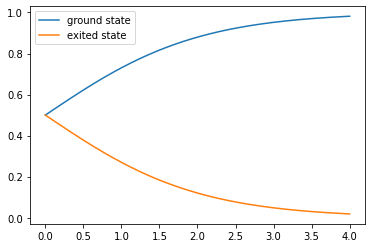

In [19]:
for i in range(50):
    ground_prob = np.zeros((50,step+1))
    exited_prob = np.zeros((50,step+1))
    
    ground_prob[i,:],exited_prob[i,:] = QMCWF2(U,L,psi_0,step)

ground_avg = np.zeros(step+1)
exited_avg = np.zeros(step+1)
for i in range(step+1):
    ground_avg[i] = np.sum(ground_prob[:,i])
    exited_avg[i] = np.sum(exited_prob[:,i])
    
plt.plot(tlist,ground_avg,label = "ground state")
plt.plot(tlist,exited_avg, label = "exited state")
plt.legend()
